## Import Libraries

In [1]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from scipy.optimize import curve_fit
from astropy.io import fits
from astropy.stats import mad_std
from photutils.segmentation import detect_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground
from photutils.centroids import centroid_com,centroid_quadratic
import statmorph
from statmorph.utils.image_diagnostics import make_figure

## Import data

In [2]:
path='Savary_training_set_lenses/'
lensed='Lens_simulations/'
non_lensed='LRG_only/'
lensed_source='lensed_source_only/'
RMS='Lenses/RMS/'
PSF='Lenses/PSF/'

files_lensed=os.listdir(path+lensed)
files_non_lensed=os.listdir(path+non_lensed)
files_lensed_source=os.listdir(path+lensed_source)
files_rms=os.listdir(path+RMS)
files_psf=os.listdir(path+PSF)

In [3]:
files=[file for file in files_lensed if (file in files_non_lensed and file in files_lensed_source and file in files_rms and file in files_psf)] #Only take files with all needed files (RMS, PSF, Lens, lensed source, non lensed)

## Data visualisation
We visualise the 9 first images of the set as example

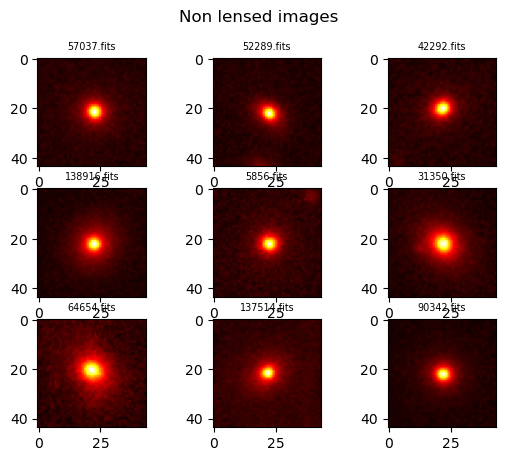

In [4]:
for count, file in zip(range(1,10),files[:9]):
    file_path=path+non_lensed+file
    image, header = fits.getdata(file_path, header=True)
    plt.suptitle('Non lensed images')
    plt.subplot(330+count)
    plt.title(file, fontsize='x-small')
    plt.imshow(image, cmap='hot')
plt.show()

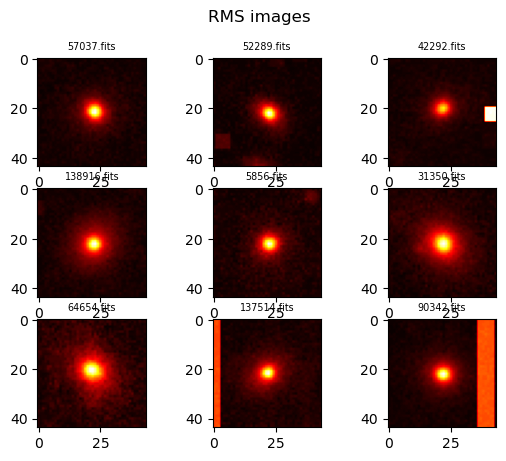

In [5]:
for count, file in zip(range(1,10),files[:9]):
    file_path=path+RMS+file
    image, header = fits.getdata(file_path, header=True)
    plt.suptitle('RMS images')
    plt.subplot(330+count)
    plt.title(file, fontsize='x-small')
    plt.imshow(image, cmap='hot')
plt.show()

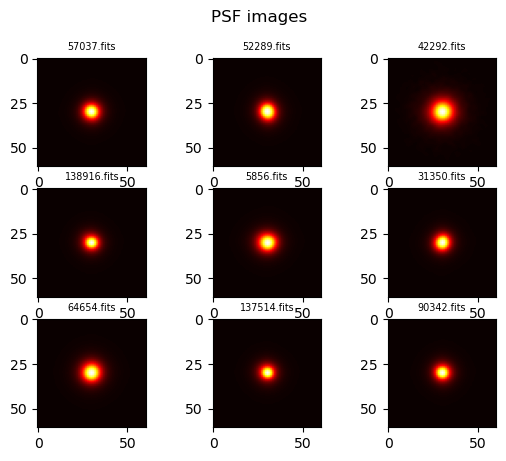

In [6]:
for count, file in zip(range(1,10),files[:9]):
    file_path=path+PSF+file
    image, header = fits.getdata(file_path, header=True)
    plt.suptitle('PSF images')
    plt.subplot(330+count)
    plt.title(file, fontsize='x-small')
    plt.imshow(image, cmap='hot')
plt.show()

## Source detection
We will detect sources and select the right segmentation mask

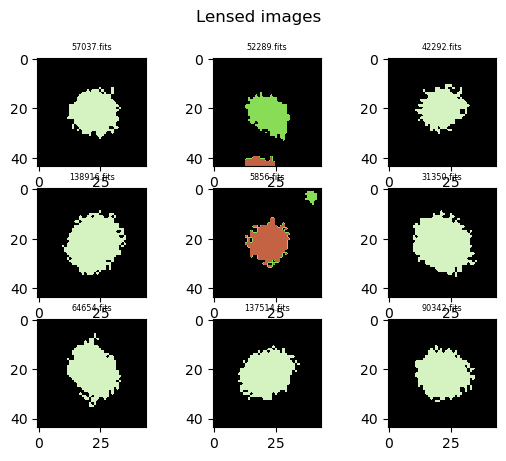

In [7]:
for count, file in zip(range(1,10),files[:9]):
    file_path=path+non_lensed+file
    image, header = fits.getdata(file_path, header=True)
    std = mad_std(image)
    threshold=2.5*std
    segm = detect_sources(image, threshold, npixels=5)
    plt.suptitle('non lensed segmentation maps')
    plt.subplot(330+count)
    plt.title(file, fontsize='xx-small')
    plt.imshow(segm.data, cmap=segm.cmap)
plt.show()

### Sorting of non-polluted galaxy images

In [9]:
clean_images_files=[]
for file in files_non_lensed:
    file_path=path+non_lensed+file
    image, header = fits.getdata(file_path, header=True)
    std = mad_std(image)
    threshold=2.5*std
    segm = detect_sources(image, threshold, npixels=5)
    if len(segm.labels)==1:
        clean_images_files.append(file)

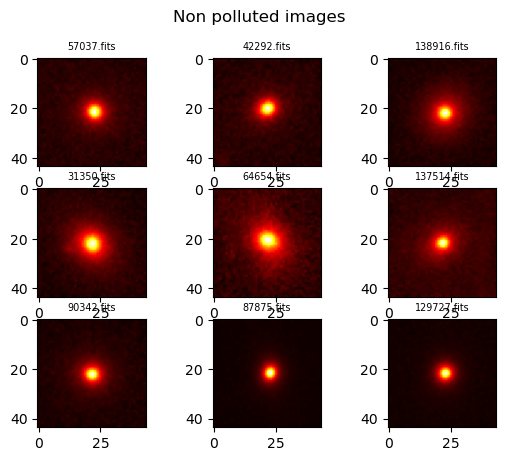

In [10]:
for count, file in zip(range(1,10),clean_images_files[:9]):
    file_path=path+non_lensed+file
    image, header = fits.getdata(file_path, header=True)
    plt.suptitle('Non polluted images')
    plt.subplot(330+count)
    plt.title(file, fontsize='x-small')
    plt.imshow(image, cmap='hot')
plt.show()

### Azimutal average

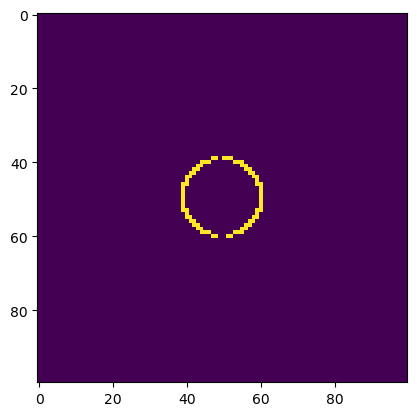

In [87]:
def pixels_circle(X_0,Y_0,R):
    coord=[]
    y_range=np.arange(-R,R,0.1)
    for y in y_range:
        x=np.sqrt(R**2-y**2)
        x1=int(X_0+x)
        x2=int(X_0-x)
        Y=int(Y_0+y)
        
        if x1==x2:
            coord.append([x1,Y])
        else:
            coord.append([x1,Y])
            coord.append([x2,Y])
    return coord

test=np.zeros([100,100])
circle=pixels_circle(50,50,10.5)#avec les x.5 les cercles sont plus beau (pourquoi ? Parceque ...)
for coord in circle:
    x=coord[0]
    y=coord[1]
    test[y,x]=1
plt.imshow(test)

In [12]:
def azimutal_average(image,X_0,Y_0,r_max,step=1):
    azimut=np.arange(0.5,r_max,step)
    average=[]
    for r in azimut:
        pixel_values=[]
        circle=pixels_circle(x_0,y_0,r)
        for coord in circle:
            x=coord[0]
            y=coord[1]
            if (x<0 or x>=x_max or y<0 or y>=x_max):
                continue
            else:
                pixel_values.append(image[y,x])
        if len(pixel_values)!=0:
            average.append(np.mean(pixel_values))
        else:
            average.append(np.nan)
    return(azimut,average)

def azimutal_std(image,X_0,Y_0,r_max,step=1):
    azimut=np.arange(0.5,r_max,step)
    std=[]
    for r in azimut:
        pixel_values=[]
        circle=pixels_circle(x_0,y_0,r)
        for coord in circle:
            x=coord[0]
            y=coord[1]
            if (x<0 or x>=x_max or y<0 or y>=x_max):
                continue
            else:
                pixel_values.append(image[y,x])
        if len(pixel_values)!=0:
            std.append(np.std(pixel_values))
        else:
            std.append(np.nan)
    return(azimut,std)

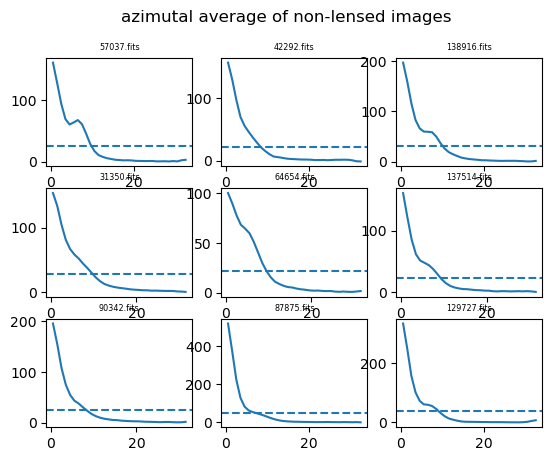

In [90]:
for count, file in zip(range(1,10),clean_images_files[:9]):
    file_path=path+lensed+file
    image, header = fits.getdata(file_path, header=True)
    
    x_0,y_0=centroid_quadratic(image)
    x_max=np.min(np.shape(image))
    
    azimut,average=azimutal_average(image,x_0,y_0,x_max)
    
    plt.suptitle('azimutal average of non-lensed images')
    plt.subplot(330+count)
    plt.title(file, fontsize='xx-small')
    plt.plot(azimut,average)
    mean=np.nanmean(average)
    plt.axhline(y = mean, linestyle = 'dashed',label=count)
plt.show()

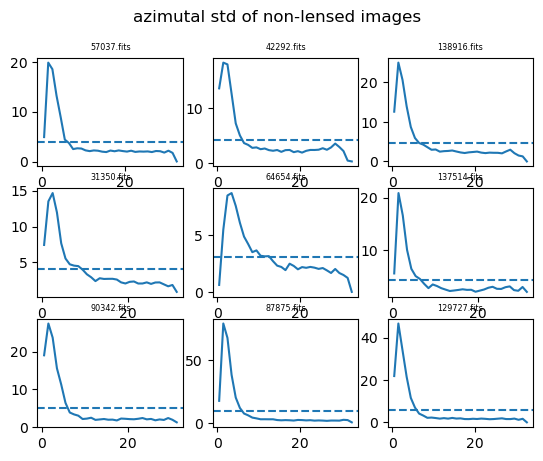

In [14]:
for count, file in zip(range(1,10),clean_images_files[:9]):
    file_path=path+non_lensed+file
    image, header = fits.getdata(file_path, header=True)
    
    x_0,y_0=centroid_quadratic(image)
    x_max=np.min(np.shape(image))
    
    azimut,stdev=azimutal_std(image,x_0,y_0,x_max)
    
    plt.suptitle('azimutal std of non-lensed images')
    plt.subplot(330+count)
    plt.title(file, fontsize='xx-small')
    plt.plot(azimut,stdev)
    mean=np.nanmean(stdev)
    plt.axhline(y = mean, linestyle = 'dashed',label=count)
plt.show()

let's look at the distribution of the too large galaxy on images. We do this by looking at the mean value of the azimutal mean and azimutal std. For a too large galaxy the mean value would increase a lot compared to a normal one because of larger values in the edges of the image.

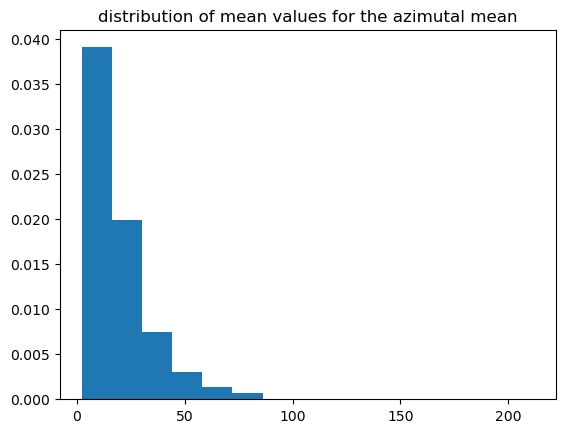

In [15]:
mean_values=[]
for file in clean_images_files[:1000]:
    file_path=path+non_lensed+file
    image, header = fits.getdata(file_path, header=True)
    
    x_0,y_0=centroid_quadratic(image)
    x_max=np.min(np.shape(image))
    
    azimut,average=azimutal_average(image,x_0,y_0,x_max)
    
    mean_values.append(np.nanmean(average))
plt.hist(mean_values,bins=15,density=True)
plt.title('distribution of mean values for the azimutal mean')
plt.show()

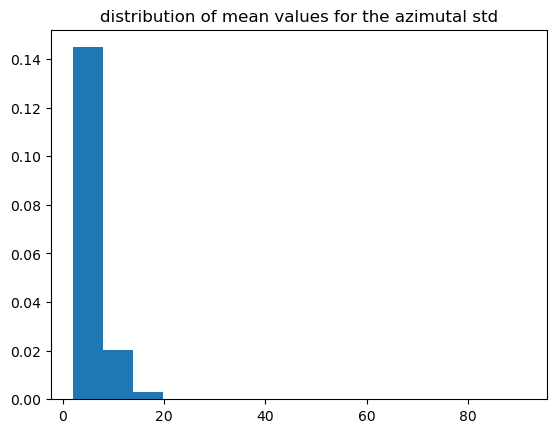

In [16]:
std_values=[]
for file in clean_images_files[:1000]:
    file_path=path+non_lensed+file
    image, header = fits.getdata(file_path, header=True)
    
    x_0,y_0=centroid_quadratic(image)
    x_max=np.min(np.shape(image))
    
    azimut,stdev=azimutal_std(image,x_0,y_0,x_max)
    
    std_values.append(np.nanmean(stdev))
plt.hist(std_values,bins=15,density=True)
plt.title('distribution of mean values for the azimutal std')
plt.show()

## Study on the RMS and its link to the data
let's try to plot the sigma sky approximated by other methods

In [17]:
def high_pass(x,y,cut):
    args=np.where(x>=cut)
    return(x[args],y[args])

def low_pass(x,y,cut):
    args=np.where(x<cut)
    return(x[args],y[args])

def f(x,a,b):
    return(a*x+b)

def g(x,a,b,c,d):
    return a*np.exp(-b*(x-c))+d

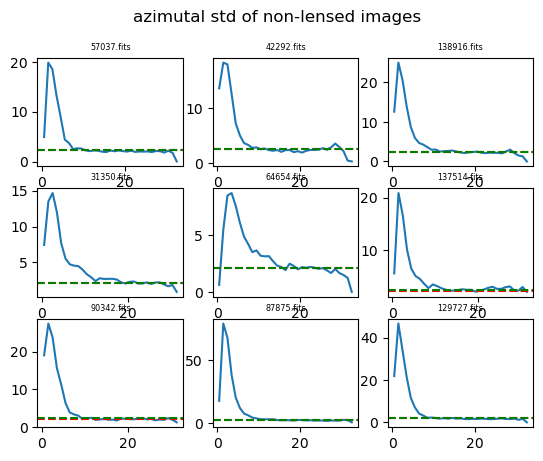

In [89]:
b,gain=[],[]
for count, file in zip(range(1,10),clean_images_files[:9]):
    file_path=path+non_lensed+file
    rms_path=path+RMS+file
    image, header = fits.getdata(file_path, header=True)
    rms,rms_header= fits.getdata(rms_path, header=True)
    
    x_0,y_0=centroid_quadratic(image)
    x_max=np.min(np.shape(image))
    
    azimut,stdev=azimutal_std(image,x_0,y_0,x_max)
    
    image=np.ravel(image)
    rms=np.ravel(rms)
    
    clean=high_pass(image,rms**2,10)
    
    popt,pcov=curve_fit(f,*clean)
    gain_rms=rms_header['gain']
    gain_image=header['GAIN']
    
    b=popt[1]
    
    clean=low_pass(image,rms**2,10)
    b2=np.mean(np.sqrt(clean[1]))
    
    plt.suptitle('azimutal std of non-lensed images')
    plt.subplot(330+count)
    plt.title(file, fontsize='xx-small')
    plt.plot(azimut,stdev)
    plt.axhline(y = np.sqrt(b), color='r',linestyle = 'dashed',label=f'b={b}')
    plt.axhline(y = b2, color='g',linestyle = '--',label=f'plateau mean={b2}')
plt.show()

### Let's get sigma_sky and mean background thanks to this method

In [19]:
def change_sign(list):
    args=[]
    for i in range(1,len(list)):
        if np.sign(list[i-1])!=np.sign(list[i]):
            args.append(i)
        else:
            continue
    return args

3.822221041394252
3.107855609467898
3.2251597213887098
4.142425836460709
1.933218882533982
3.7601167418527885
1.9969360400388034
1.9645221269336497
3.767836841594732


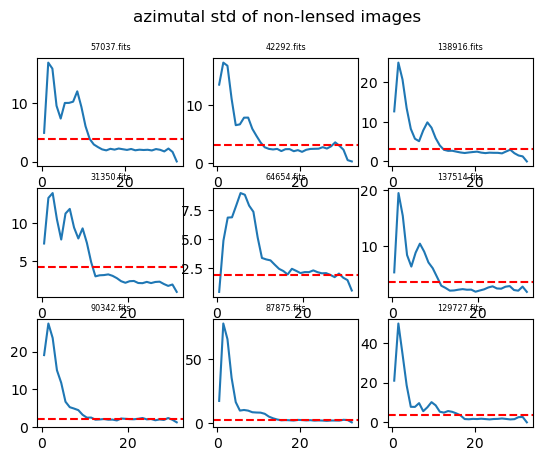

In [111]:
stds=[]
for count, file in zip(range(1,10),clean_images_files[:9]):
    file_path=path+non-lensed+file
    image, header = fits.getdata(file_path, header=True)
    
    x_0,y_0=centroid_quadratic(image)
    x_max=np.min(np.shape(image))
    
    azimut,stdev=azimutal_std(image,x_0,y_0,x_max)
    
    deriv=np.gradient(stdev,azimut)
    arg=change_sign(deriv)[1]
    
    az_clean=azimut[arg:]
    stdev_clean=stdev[arg:]
    sigma_sky=np.nanmean(stdev_clean)
    stds.append(sigma_sky)
    
    print(sigma_sky)
    
    plt.suptitle('azimutal std of non-lensed images')
    plt.subplot(330+count)
    plt.title(file, fontsize='xx-small')
    plt.plot(azimut,stdev)
    plt.axhline(y = sigma_sky, color='r',linestyle = 'dashed',label=f'b={b}')
plt.show()

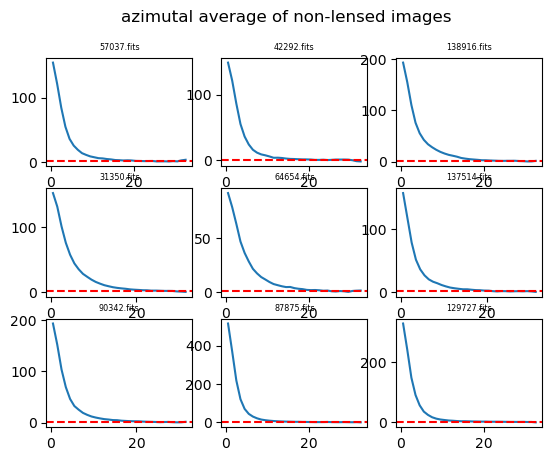

In [21]:
for count, file in zip(range(1,10),clean_images_files[:9]):
    file_path=path+non_lensed+file
    image, header = fits.getdata(file_path, header=True)
    
    x_0,y_0=centroid_quadratic(image)
    x_max=np.min(np.shape(image))
    
    azimut,average=azimutal_average(image,x_0,y_0,x_max)
    
    mean_bkg=np.nanmean(average[-20:])
    
    plt.suptitle('azimutal average of non-lensed images')
    plt.subplot(330+count)
    plt.title(file, fontsize='xx-small')
    plt.plot(azimut,average)
    plt.axhline(y = mean_bkg, color='r',linestyle = 'dashed',label=f'b={b}')
plt.show()

### on estime le pourcentage d'occupation par de l'image en prenant un treshold=sigma_sky

In [22]:
def galaxy_map(segm):
    label = np.argmax(segm.areas)+1
    segm_map=1*(segm.data==label)
    return segm_map

def galaxy_label(segm):
    label = np.argmax(segm.areas)+1
    return label

def mask(segm):
    galaxy=(galaxy_map(segm))
    segm_map=segm.data!=0
    mask=segm_map-galaxy
    bool_mask=mask==1
    return bool_mask

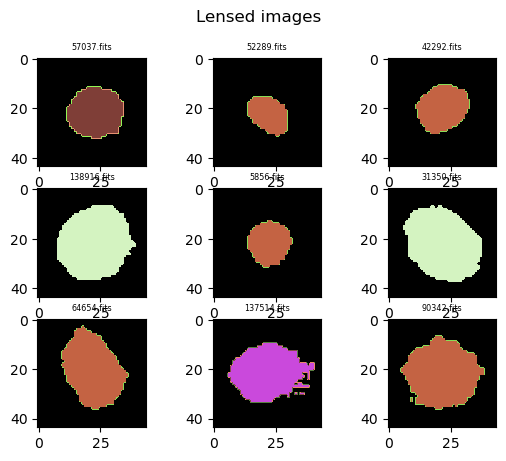

In [95]:
coverage=[]
for count, file in zip(range(10),files[:9]):
    file_path=path+non_lensed+file
    image, header = fits.getdata(file_path, header=True)
    std = stds[count]
    threshold=3*std
    segm = detect_sources(image, threshold, npixels=5)
    
    segm_map=galaxy_map(segm)

    segmap_float = ndi.uniform_filter(np.float64(segm_map), size=5)
    segm_map = segmap_float > 0.5

    Mask=mask(segm)
    
    plt.suptitle('Lensed images')
    plt.subplot(330+count+1)
    plt.title(file, fontsize='xx-small')
    plt.imshow(segm_map, cmap=segm.cmap)
plt.show()

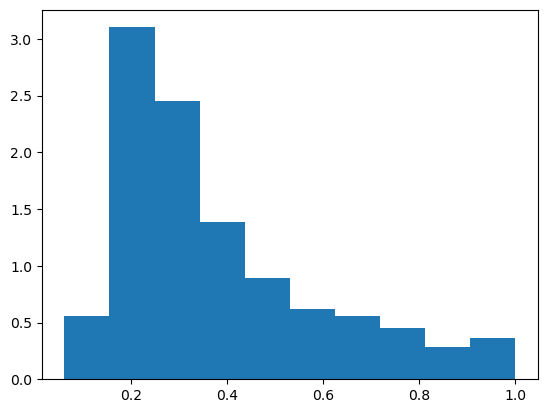

0.37935485537190083


In [97]:
coverage=[]
for file in clean_images_files[:1000]:
    file_path=path+non_lensed+file
    image, header = fits.getdata(file_path, header=True)
    
    x_0,y_0=centroid_quadratic(image)
    x_max=np.min(np.shape(image))
    
    azimut,stdev=azimutal_std(image,x_0,y_0,x_max)
    
    deriv=np.gradient(stdev,azimut)
    arg=change_sign(deriv)[1]
    
    az_clean=azimut[arg:]
    stdev_clean=stdev[arg:]
    sigma_sky=np.nanmean(stdev_clean)
    
    
    threshold=1.5*sigma_sky
    segm = detect_sources(image, threshold, npixels=5)
    
    segm_map=galaxy_map(segm)

    segmap_float = ndi.uniform_filter(np.float64(segm_map), size=5)
    segm_map = segmap_float > 0.5

    Mask=mask(segm)
    
    ravel=1*segm_map
    coverage.append(np.count_nonzero(ravel)/44**2)
    
plt.hist(coverage, density=True)
plt.show()
print(np.mean(coverage))

In [51]:
np.median(coverage)

0.4271694214876033

### essayons de fitter un sersic avec statmorph si il y a trop de problème essayons d'enlever les galaxies trop grosses

57037.fits
coverage=0.2840909090909091
flag_sersic=0
flag=0
sersic_amplitude = 18.272938184847703
sersic_rhalf = 0.9481829614070532
sersic_n = 10.500659364540034
sersic_xc = 22.984114953397178
sersic_yc = 22.01093517982337
sersic_ellip = 0.6695582589544353
sersic_theta = 2.3775293900236396 

42292.fits
coverage=0.26704545454545453
flag_sersic=0
flag=0
sersic_amplitude = 40.43177599748898
sersic_rhalf = 4.156461213468561
sersic_n = 6.184061438905523
sersic_xc = 20.928531099044207
sersic_yc = 20.003445725038485
sersic_ellip = 0.9609833549919473
sersic_theta = 3.07638528936284 



138916.fits
coverage=0.4824380165289256
flag_sersic=1
flag=0
sersic_amplitude = 33.08965551934829
sersic_rhalf = 5.521813851479409
sersic_n = 14.109246870935538
sersic_xc = 22.69714988246706
sersic_yc = 22.101927002952433
sersic_ellip = 0.3234750619144185
sersic_theta = 2.409842345984748 

31350.fits
coverage=0.5139462809917356
flag_sersic=0
flag=0
sersic_amplitude = 10.366549192548664
sersic_rhalf = 12.305206627487511
sersic_n = 3.9104724880517474
sersic_xc = 21.995049494676245
sersic_yc = 21.997797128588218
sersic_ellip = 0.477845366090917
sersic_theta = 0.7095908701110989 



64654.fits
coverage=0.4772727272727273
flag_sersic=1
flag=0
sersic_amplitude = 10.631636192400869
sersic_rhalf = 10.405950894894868
sersic_n = 15.139166155006661
sersic_xc = 21.835461589634615
sersic_yc = 20.702031439535833
sersic_ellip = 0.6702007552980057
sersic_theta = 0.9969523235153291 



137514.fits
coverage=0.32644628099173556
flag_sersic=1
flag=0
sersic_amplitude = 2.2226055925872163
sersic_rhalf = 22.811026526604685
sersic_n = 8.031284160691776
sersic_xc = 21.945290468509867
sersic_yc = 22.026941661862004
sersic_ellip = 0.8007269145538467
sersic_theta = 2.580256218570973 

90342.fits
coverage=0.4121900826446281
flag_sersic=0
flag=0
sersic_amplitude = 25.80790373662181
sersic_rhalf = 3.5629504324746835
sersic_n = 7.747957309897344
sersic_xc = 21.947897290730236
sersic_yc = 21.962320151283542
sersic_ellip = 0.8714030881632673
sersic_theta = 0.6119346297595868 



87875.fits
coverage=0.3884297520661157
flag_sersic=1
flag=0
sersic_amplitude = 38.18958343577682
sersic_rhalf = -1.756326235641544
sersic_n = 28.703937805680493
sersic_xc = 22.9832081012845
sersic_yc = 21.95538626619877
sersic_ellip = 1.1833785641711008
sersic_theta = 1.222746429308515 

129727.fits
coverage=0.4121900826446281
flag_sersic=0
flag=0
sersic_amplitude = 79.45395818207666
sersic_rhalf = 3.499352364244849
sersic_n = 5.177027306414603
sersic_xc = 22.988554338029676
sersic_yc = 21.933860864735028
sersic_ellip = 1.01734016359835
sersic_theta = 1.4009361632771633 

91102.fits
coverage=0.365702479338843
flag_sersic=0
flag=0
sersic_amplitude = 28.1526932677382
sersic_rhalf = 5.032841413675796
sersic_n = 4.491571814761984
sersic_xc = 21.980327039164074
sersic_yc = 20.97895377059488
sersic_ellip = 0.8354413833991362
sersic_theta = 0.8415239074617703 



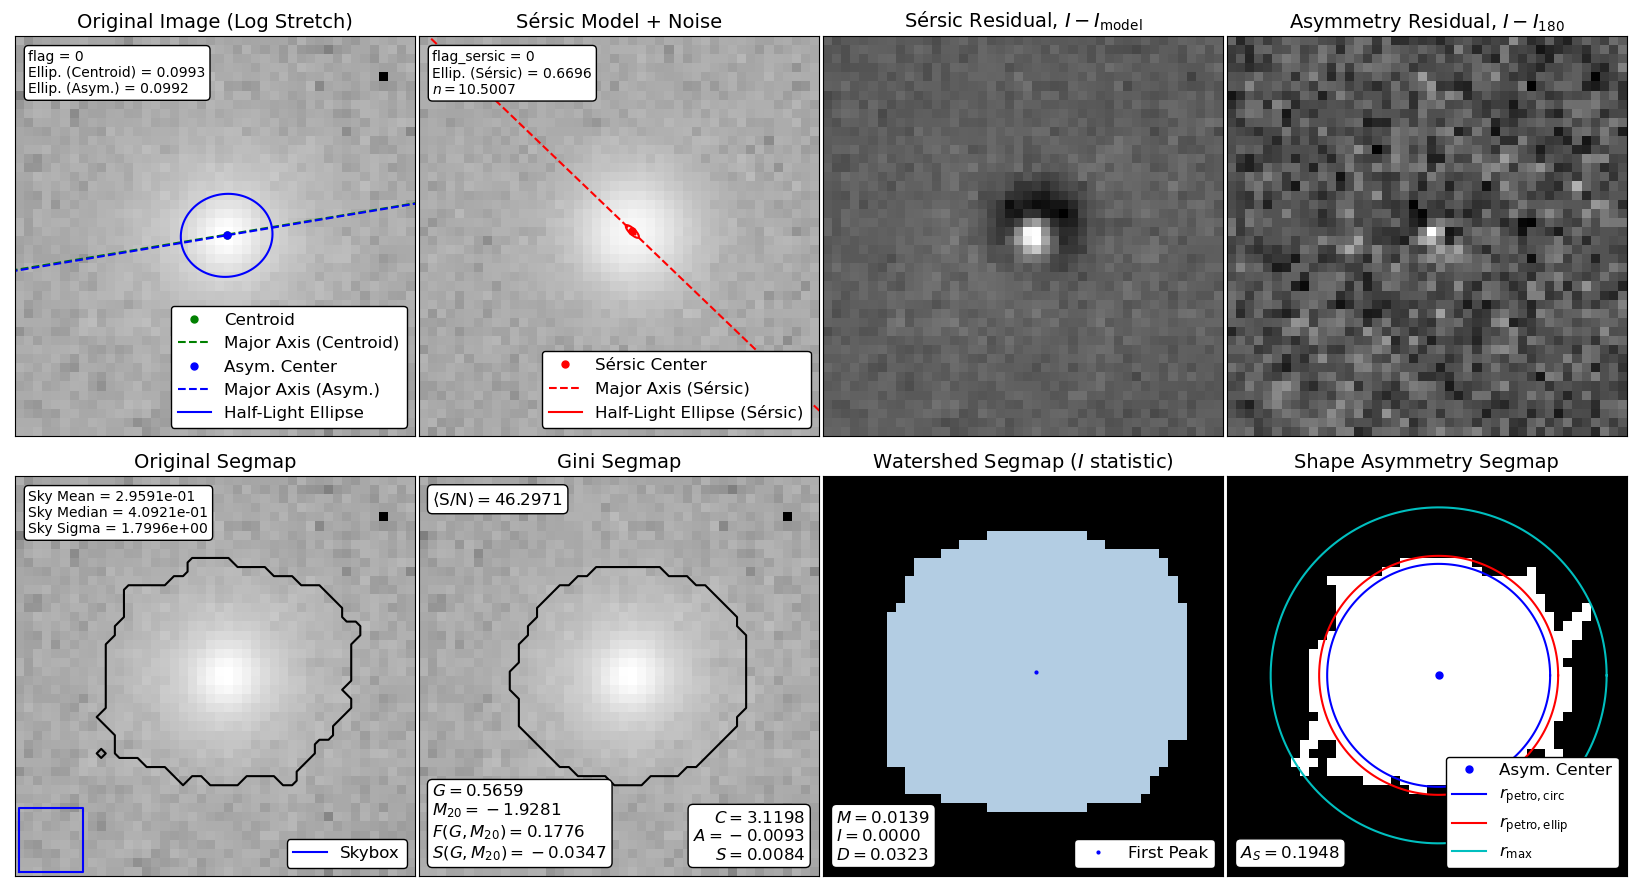

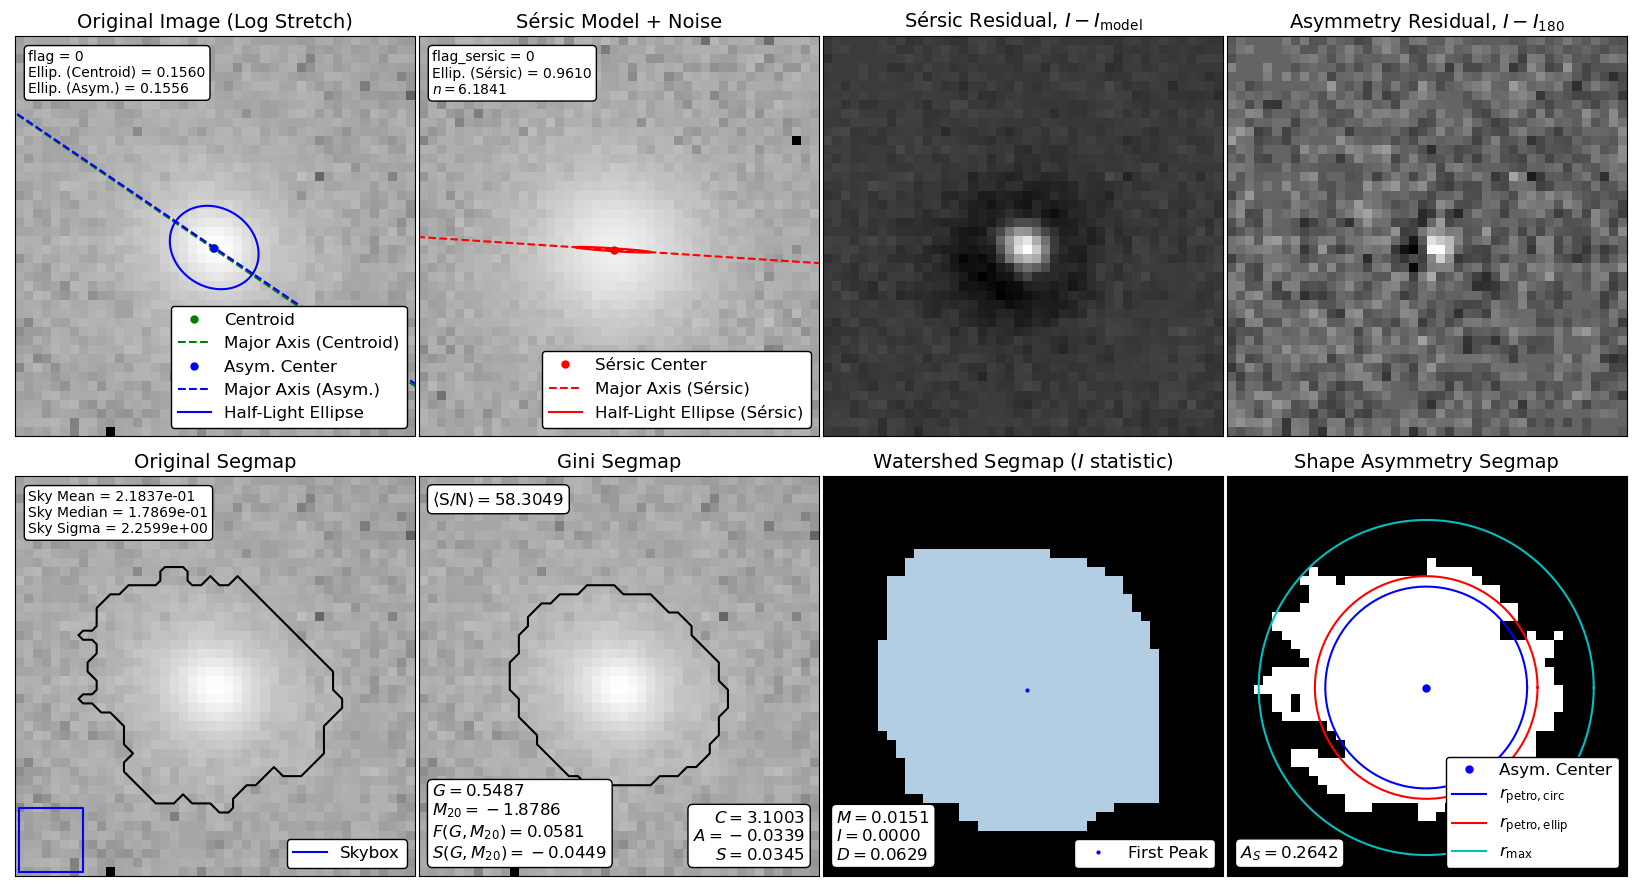

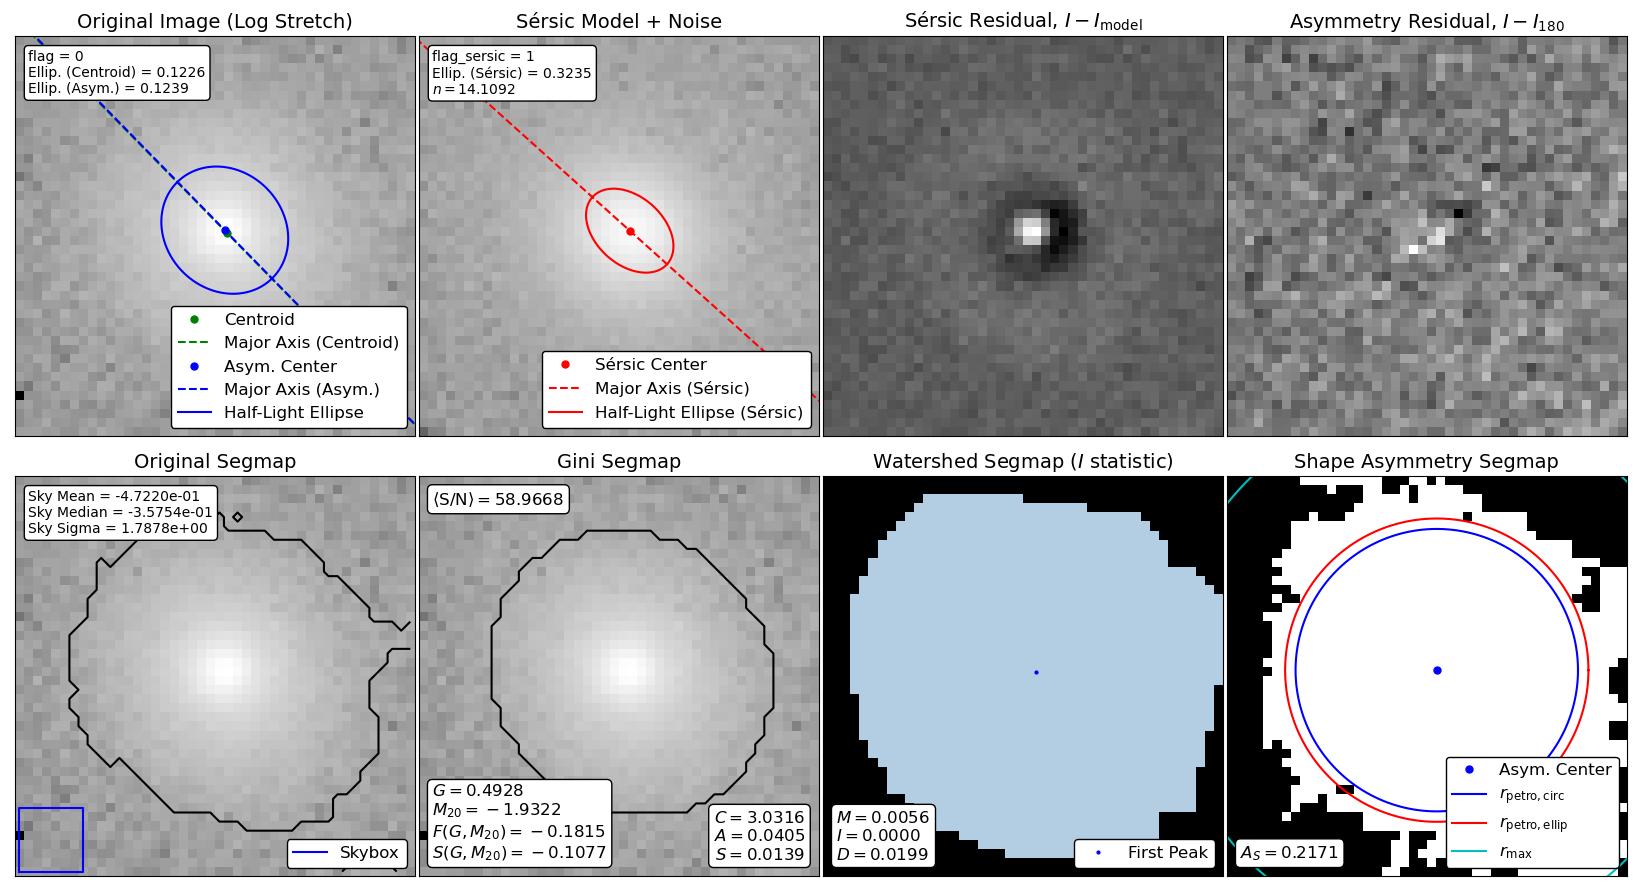

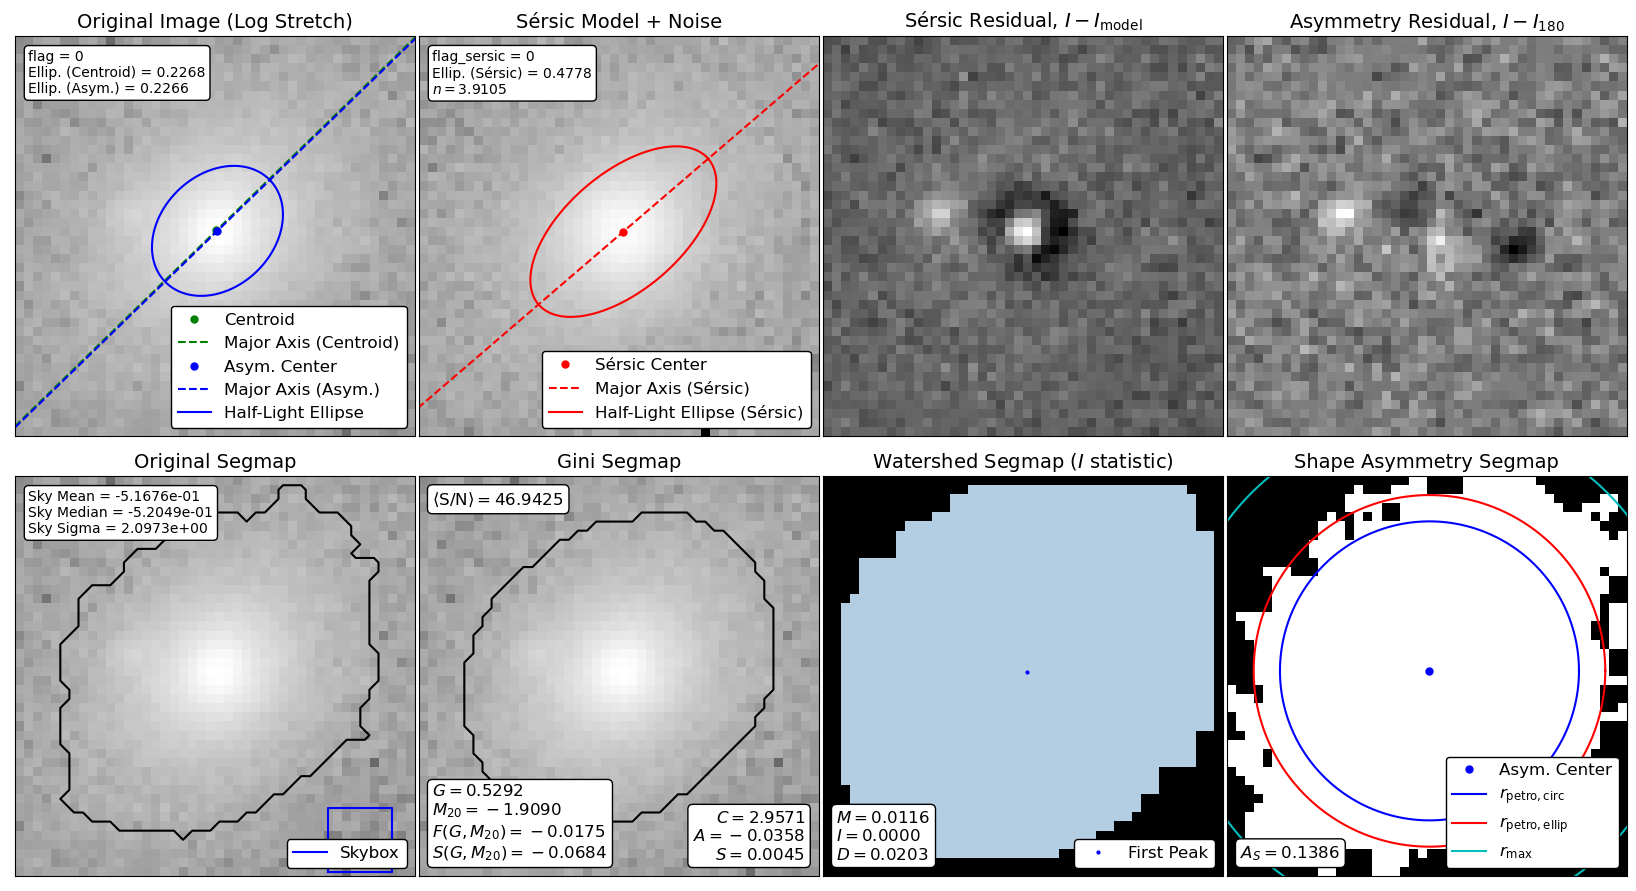

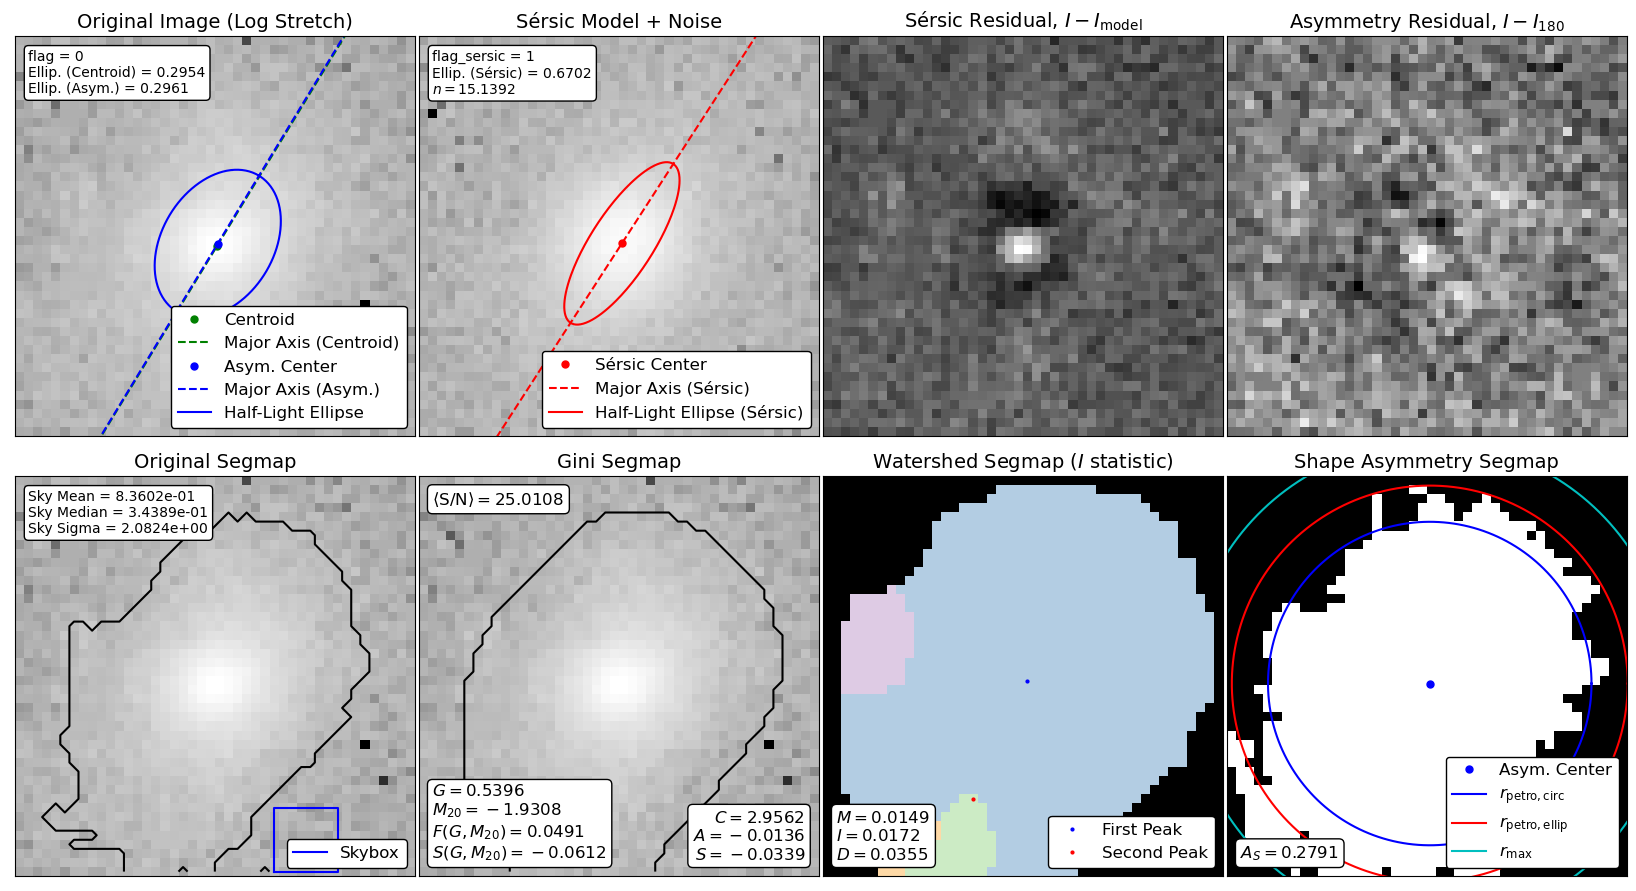

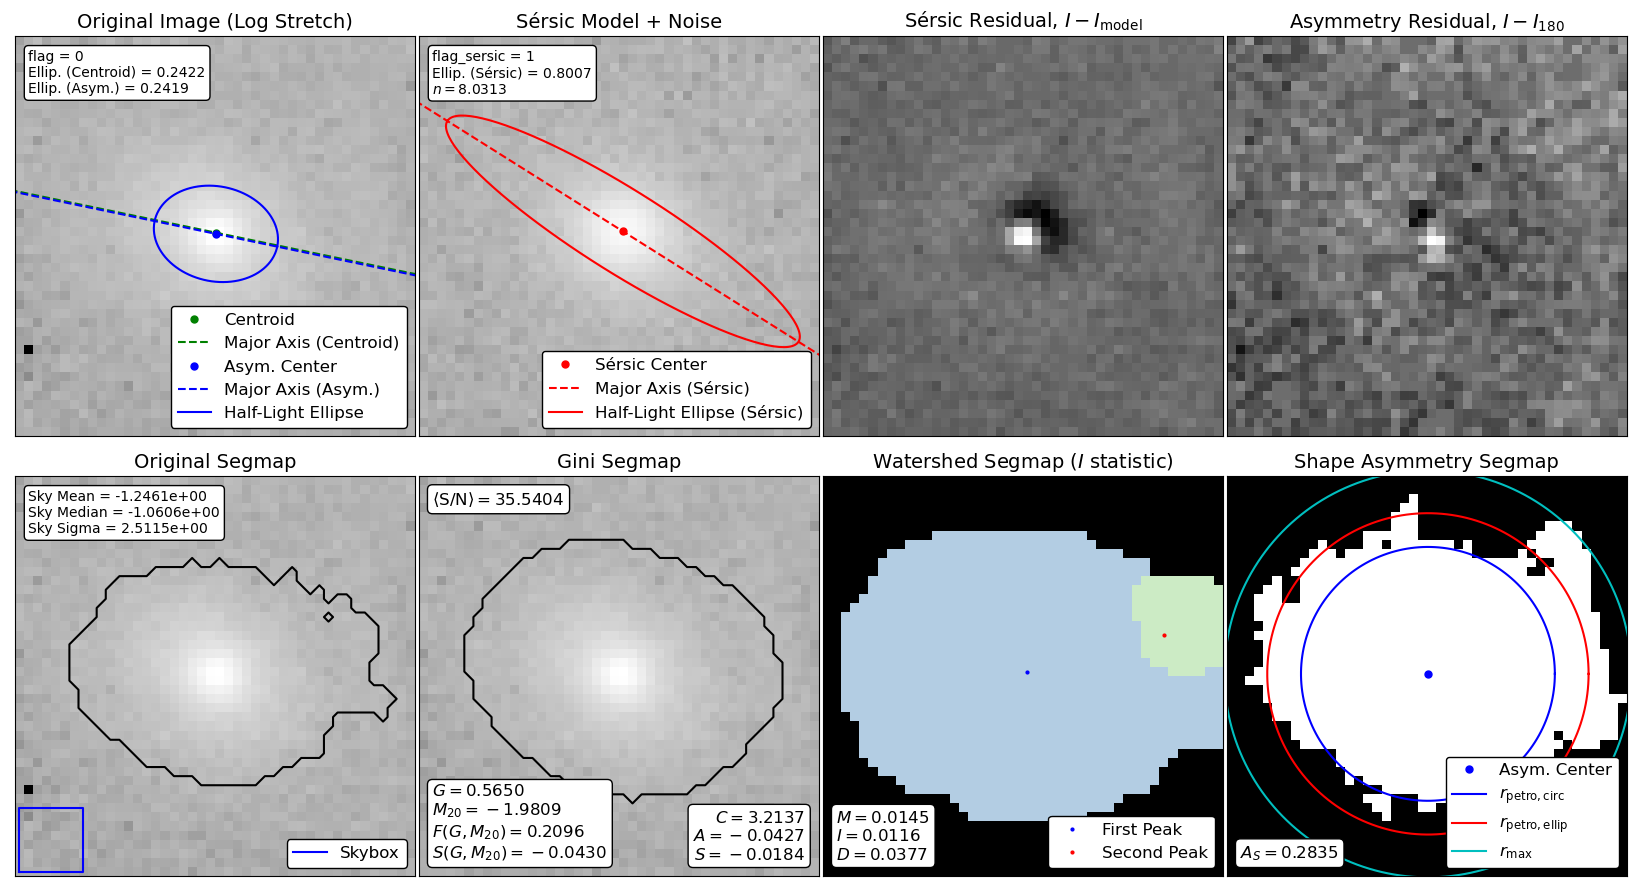

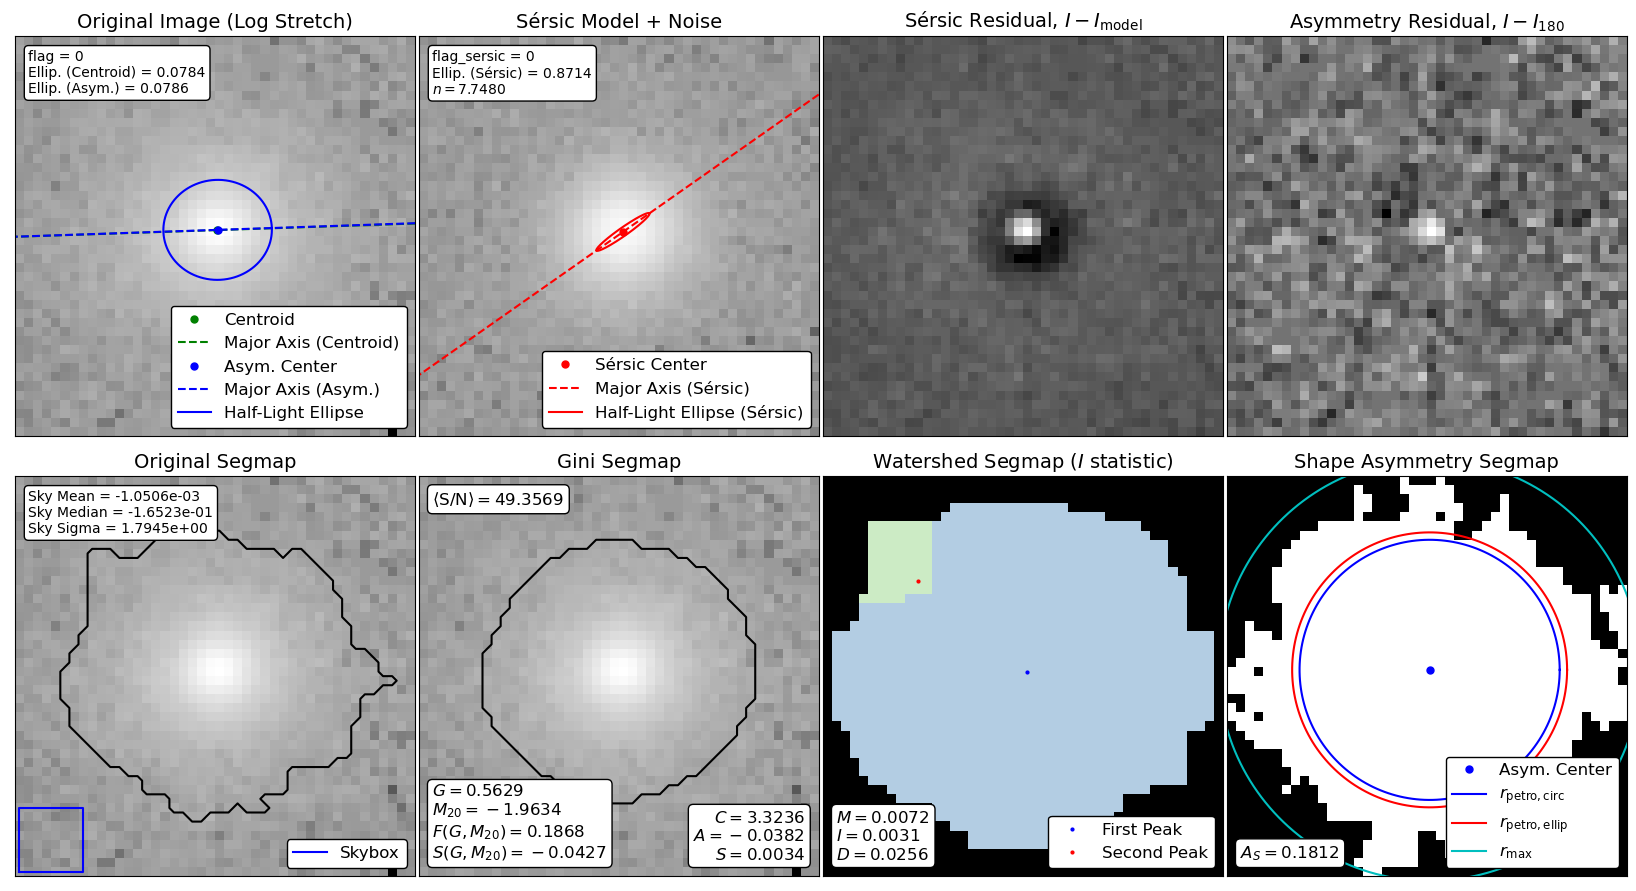

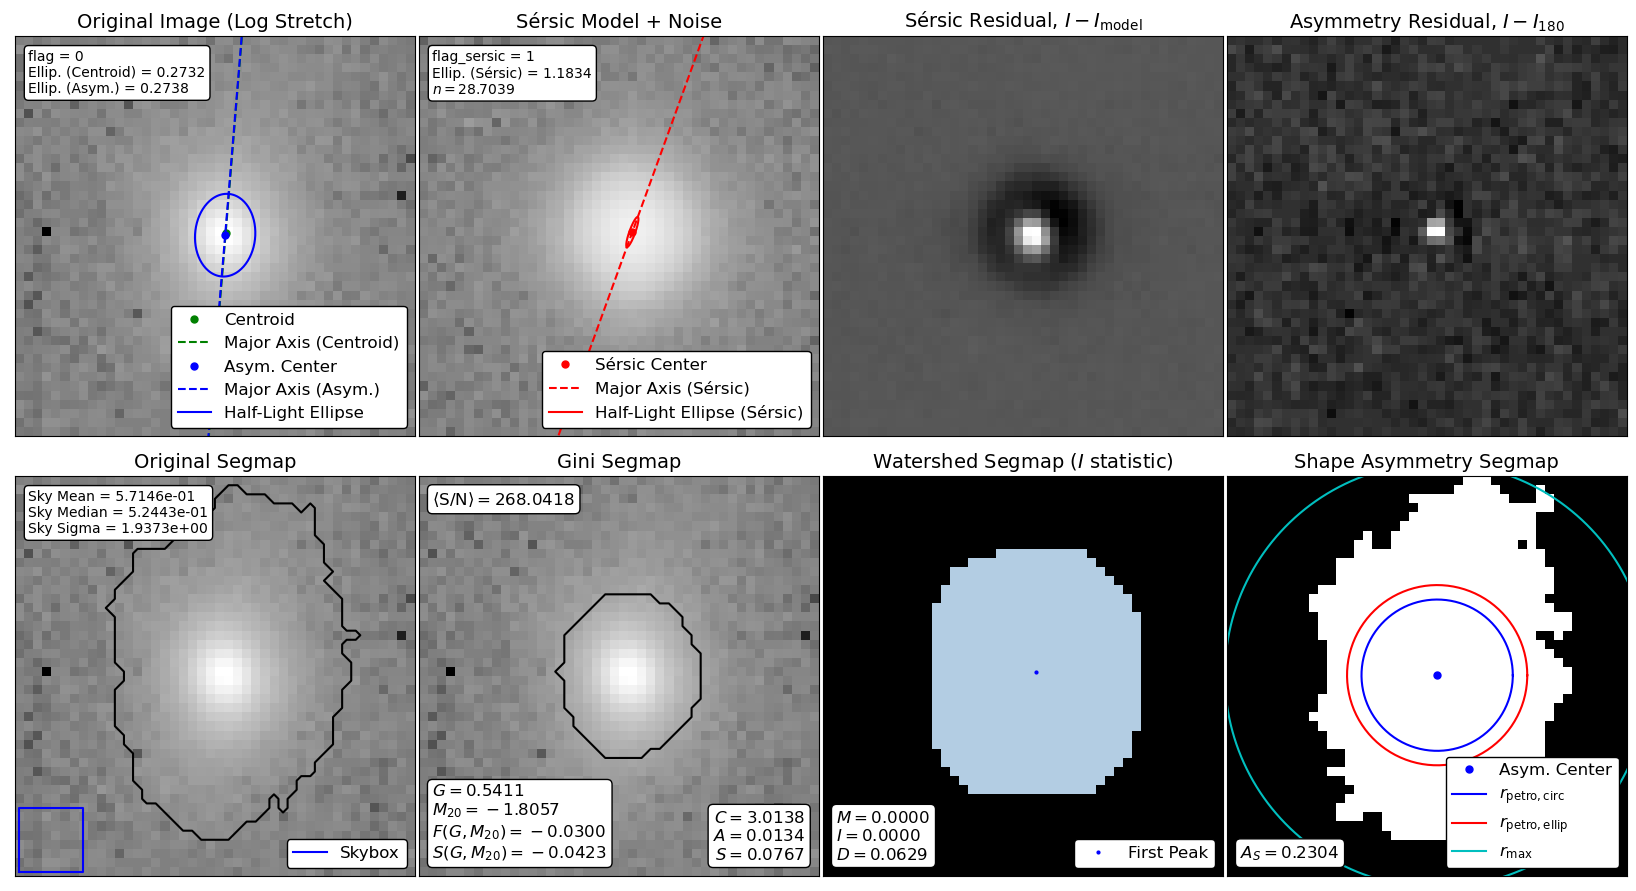

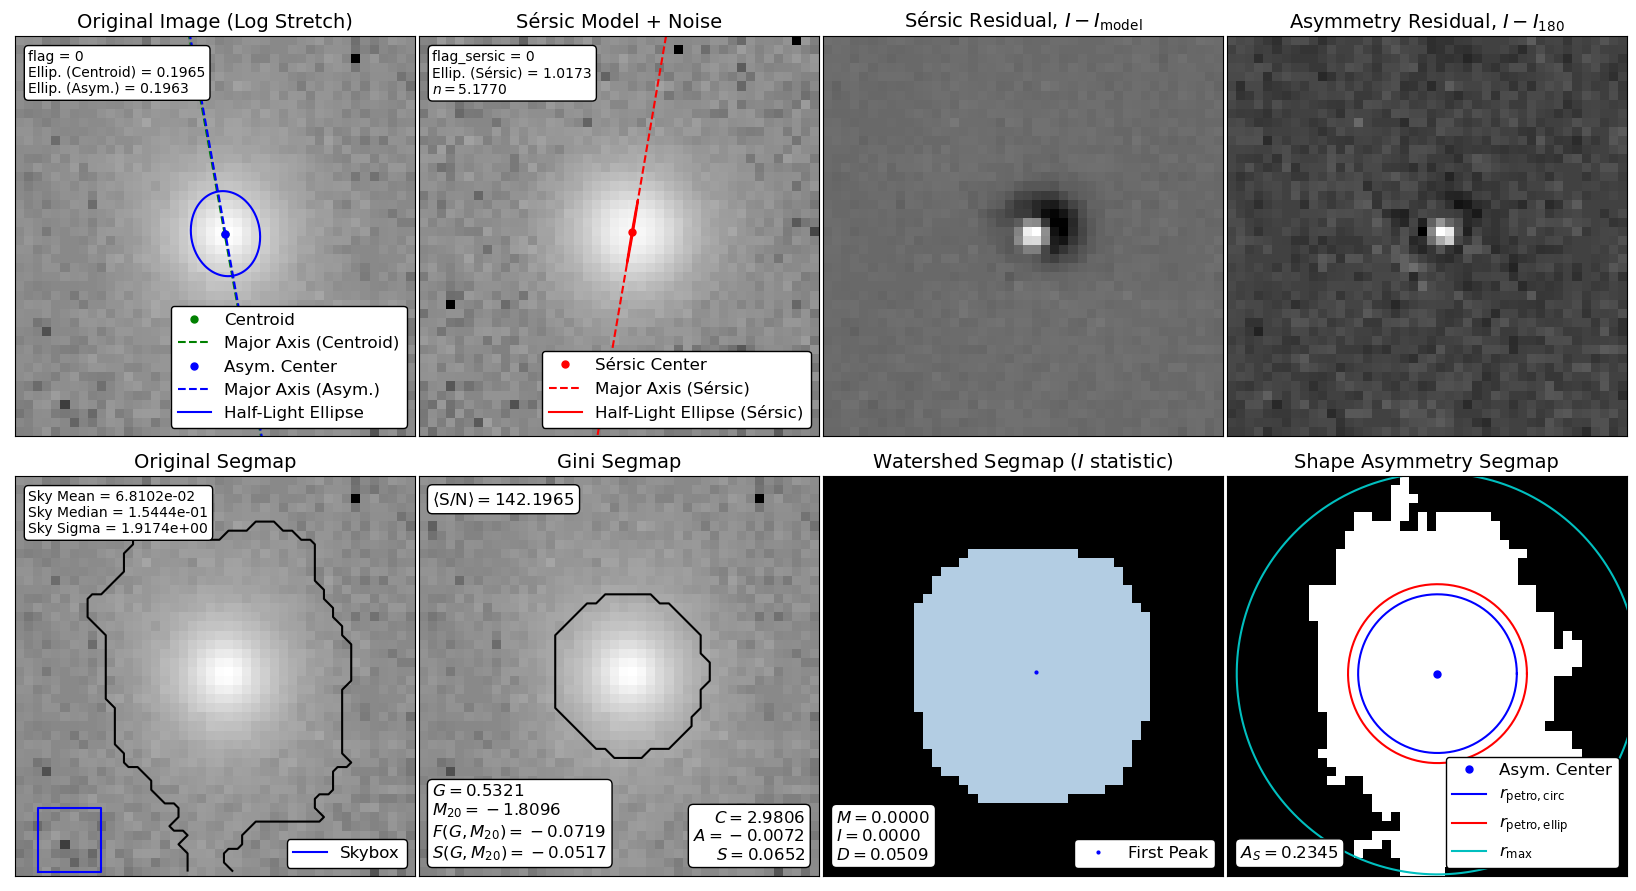

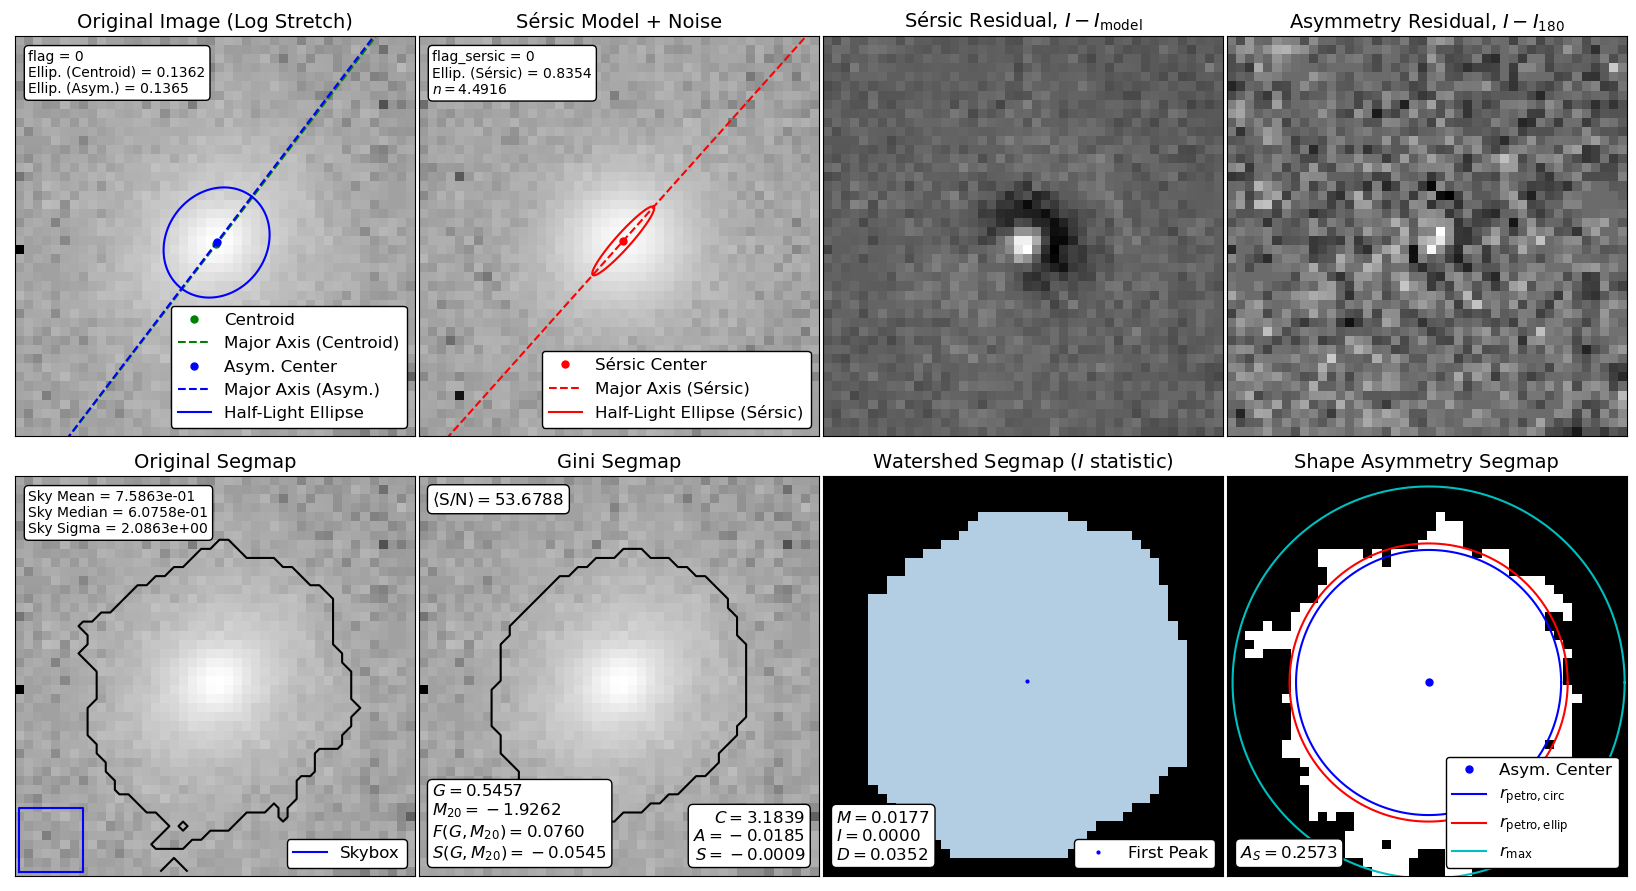

In [110]:
for file in clean_images_files[:10]:
    file_path=path+non_lensed+file
    image, header = fits.getdata(file_path, header=True)
    rms_path=path+RMS+file
    rms,rms_header=fits.getdata(rms_path,header=True)
    psf_path=path+PSF+file
    psf,psf_header=fits.getdata(psf_path,header=True)
    
    x_0,y_0=centroid_quadratic(image)
    x_max=np.min(np.shape(image))
    
    azimut,stdev=azimutal_std(image,x_0,y_0,x_max)
    azimut,average=azimutal_average(image,x_0,y_0,x_max)
    
    mean_bkg=np.nanmean(average[-20:])
    image-=mean_bkg
    
    deriv=np.gradient(stdev,azimut)
    arg=change_sign(deriv)[1]
    
    az_clean=azimut[arg:]
    stdev_clean=stdev[arg:]
    sigma_sky=np.nanmean(stdev_clean)
    
    threshold=1.5*sigma_sky
    segm = detect_sources(image, threshold, npixels=5)
    
    Mask=mask(segm)
    segm_map=galaxy_map(segm)
        
    segmap_float = ndi.uniform_filter(np.float64(segm_map.data), size=5)
    segm_map =1*(segmap_float > 0.5)
    
    ravel=1*segm_map
    coverage=np.count_nonzero(ravel)/44**2
    
    # construction de la rms
    
    weight_map=1/rms
    
    #estimation of the background
    #let's take the median estimator
        
    try:
        source_morphs = statmorph.source_morphology(image, segm_map, weightmap=weight_map, mask=Mask,psf=psf)
        morph = source_morphs[0]
        print(file)
        print(f'coverage={coverage}')
        print(f'flag_sersic={morph.flag_sersic}')
        print(f'flag={morph.flag}')
        print('sersic_amplitude =', morph.sersic_amplitude)
        print('sersic_rhalf =', morph.sersic_rhalf)
        print('sersic_n =', morph.sersic_n)
        print('sersic_xc =', morph.sersic_xc)
        print('sersic_yc =', morph.sersic_yc)
        print('sersic_ellip =', morph.sersic_ellip)
        print('sersic_theta =', morph.sersic_theta,'\n')
        fig = make_figure(morph)
    except:
        print('bug')

### Test avec Sersic 2D du module astropy

In [93]:
from astropy.modeling.models import Sersic2D
from astropy.modeling import fitting

fit_p = fitting.LevMarLSQFitter()

for file in clean_images_files[:100]:
    file_path=path+non_lensed+file
    image, header = fits.getdata(file_path, header=True)
    
    x_0,y_0=centroid_quadratic(image)
    x_max=np.min(np.shape(image))
    
    azimut,average=azimutal_average(image,x_0,y_0,x_max)
    
    mean_bkg=np.nanmean(average[-20:])
    
    ravel=1*segm_map
    coverage=np.count_nonzero(ravel)/44**2
    
    image-=mean_bkg
    model=Sersic2D()
    
    x = np.linspace(1, 44, 44)
    y = np.linspace(1, 44, 44)
    x,y = np.meshgrid(x, y)
    p = fit_p(model, x, y, image)

NonFiniteValueError: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.